In [1]:
import pandas as pd
raw_data = pd.read_json("../../sciso.jsonl", lines=True)

In [5]:
from pymongo import MongoClient
from tqdm import tqdm

db = MongoClient("localhost", 27017).get_database("sciso-2024")
pub_refs = db.get_collection("pub_refs")
posts = db.get_collection("posts")


def update_post_meta():
    cursor = pub_refs.find({})
    for doc in tqdm(cursor, total=pub_refs.count_documents({})):
        post = posts.find_one({"Id": doc["PostId"]})
        if post is None:
            print(f"{doc['PostId']} not found")
        doc["PostTypeId"] = post.get("PostTypeId", None)
        doc["Score"] = post.get("Score", None)
        doc["ViewCount"] = post.get("ViewCount", None)
        doc["AnswerCount"] = post.get("AnswerCount", None)
        doc["CommentCount"] = post.get("CommentCount", None)
        doc["FavoriteCount"] = post.get("FavoriteCount", None)
        pub_refs.update_one({"_id": doc["_id"]}, {"$set": doc})

# update_post_meta()

In [3]:
def flatten(df: pd.DataFrame):
    retval = pd.DataFrame(list(df["metadata"]))
    retval = retval[
        [
            "title",
            "normalized_venue",
            "year",
            "citation_count",
            "authors",
            "type",
            "open_access",
            "concepts",
        ]
    ].join(df[["PostId", "AddedAt"]])
    retval["year"] = retval["year"].astype("Int64")
    retval["AddedAt"] = pd.to_datetime(retval["AddedAt"])
    retval["AddedAt"] = retval["AddedAt"].dt.year
    return retval


def filter_concepts(row):
    concepts = row["concepts"]
    try:
        concepts.sort(key=lambda x: x["score"], reverse=True)
    except Exception:
        row["concepts"] = []
        return row
    filtered_concepts = []
    for concept in row["concepts"]:
        if concept["level"] > 1:
            continue
        if "computer interaction" in concept["display_name"]:
            concept["display_name"] = "human computer interaction"
        elif "time computing" in concept["display_name"]:
            concept["display_name"] = "real time computing"
        elif "Computer graphics" in concept["display_name"]:
            concept["display_name"] = "computer graphics images"
        elif "risk analysis" in concept["display_name"]:
            concept["display_name"] = "risk analysis"
        filtered_concepts.append(
            {
                "name": concept["display_name"].lower(),
                "score": concept["score"],
                "level": concept["level"],
            }
        )
    row["concepts"] = filtered_concepts
    return row


def get_l1_field_of_research(row: pd.Series):
    for con in row["concepts"]:
        if con["score"] <= 0.1:
            continue
        if con["level"] == 1:
            row["l1_field"] = con["name"]
            return row
    row["l1_field"] = None
    return row


cs_l1_fields = [
    "geometry",
    "algorithm",
    "multimedia",
    "database",
    "internet privacy",
    "natural language processing",
    "data science",
    "embedded system",
    "artificial intelligence",
    "real time computing",
    "statistics",
    "distributed computing",
    "computer hardware",
    "software engineering",
    "arithmetic",
    "mathematical economics",
    "mathematical optimization",
    "theoretical computer science",
    "computer architecture",
    "computer graphics images",
    "library science",
    "simulation",
    "telecommunications",
    "operating system",
    "discrete mathematics",
    "world wide web",
    "mathematics education",
    "parallel computing",
    "computational science",
    "information retrieval",
    "computer security",
    "knowledge management",
    "pure mathematics",
    "computer vision",
    "data mining",
    "econometrics",
    "speech recognition",
    "operations research",
    "mathematical physics",
    "computer engineering",
    "programming language",
    "human computer interaction",
    "computer network",
    "machine learning",
    "applied mathematics",
    "combinatorics",
    "mathematical analysis",
]

math_l1_fields = [
    "geometry",
    "algorithm",
    "statistics",
    "arithmetic",
    "mathematical economics",
    "mathematical optimization",
    "discrete mathematics",
    "mathematics education",
    "computational science",
    "pure mathematics",
    "econometrics",
    "operations research",
    "mathematical physics",
    "applied mathematics",
    "combinatorics",
    "mathematical analysis",
]


def get_field_of_research(row: pd.Series):
    top_l0 = None
    top_l1 = None
    for con in row["concepts"]:
        if con["score"] <= 0.1:
            continue
        if con["level"] == 1:
            if con["name"] in cs_l1_fields:
                if top_l1 is None:
                    top_l1 = con["name"]
                # elif top_l1 == "artificial intelligence" and con["name"] in {"computer vision", "machine learning", "natural language processing"} and con["score"] >= 0.5:
                #     top_l1 = con["name"]
            elif con["name"] in math_l1_fields:
                if top_l1 is None:
                    top_l1 = con["name"]
        elif con["level"] == 0:
            top_l0 = con["name"]
    row["field"] = top_l1 or top_l0
    return row


def process_concepts(df: pd.DataFrame):
    retval = df.apply(filter_concepts, axis=1)
    retval = retval.apply(get_l1_field_of_research, axis=1)
    retval = retval.apply(get_field_of_research, axis=1)
    return retval

def handle_year_duplicates(row):
    non_na = [x for x in row if pd.notna(x)]
    return min(non_na) if non_na else None

def group_by_title(df: pd.DataFrame):
    retval = (
        df.groupby("title")
        .agg(
            {
                "normalized_venue": lambda x: set(x),
                "year": lambda x: set(x),
                "citation_count": "max",
                "open_access": "any",
                "PostId": lambda x: set(x),
                "field": lambda x: set(x),
                "AddedAt": list,
            }
        )
        .reset_index()
    )
    if any(retval["normalized_venue"].apply(len) > 1):
        print("Warning: multiple venues for the same title")
        # else:
        retval["normalized_venue"] = retval["normalized_venue"].apply(
            lambda x: ([x for x in x if pd.notna(x)] or [None])[0]
        )
    if any(retval["year"].apply(len) > 1):
        print("Warning: multiple years for the same title")
        # else:
        retval["year"] = retval["year"].apply(lambda x: min([x for x in x if pd.notna(x)] or [None]))
    if any(retval["field"].apply(len) > 1):
        print("Warning: multiple fields for the same title")
        # else:
        retval["field"] = retval["field"].apply(lambda x: ([x for x in x if pd.notna(x)] or [None])[0])
    return retval


pd.set_option("display.max_rows", 10)
flattened_data = process_concepts(flatten(raw_data))
grouped_data = group_by_title(flattened_data)
grouped_data

,title,normalized_venue,year,citation_count,open_access,PostId,field,AddedAt
0,Neural Network Methods for Natural Language P...,Computational Linguistics,2017.0,549.0,True,{48445189},artificial intelligence,[2018]
1,"""Low-Resource"" Text Classification: A Paramete...",Annual Meeting of the Association for Computat...,2023.0,52.0,True,{76724158},artificial intelligence,[2023]
2,"#ifdef Considered Harmful, or Portability Expe...",Usenix summer,1992.0,246.0,False,"{489434, 8012461, 21097319, 9294487}",computer security,"[2022, 2012, 2018, 2014]"
3,$2.00 Gas! Studying the Effects of a Gas Tax M...,Journal of Public Economics,2008.0,162.0,True,{75879031},economics,[2023]
4,"$\mu $ RNG: A 300–950 mV, 323 Gbps/W All-Digit...",IEEE Journal of Solid-State Circuits,2016.0,83.0,False,{61554191},algorithm,[2020]
...,...,...,...,...,...,...,...,...
13282,“One Against One” or “One Against All”: Which ...,International Conference on Frontiers in Handw...,2006.0,272.0,False,"{16728386, 16252899, 16793390}",artificial intelligence,"[2013, 2013, 2013]"
13283,"“Search, Show Context, Expand on Demand”: Supp...",IEEE Transactions on Visualization and Compute...,2009.0,257.0,False,{21893401},information retrieval,[2014]
13284,“Should This Loan be Approved or Denied?”: A L...,Journal of statistics education,2018.0,33.0,True,{64403934},operations research,[2020]
13285,“We Are Here to Help”Who Opens the Gate for Su...,Tsq transgender studies quarterly,2018.0,10.0,False,"{5017208, 58591979, 14537012, 5151693}",computer science,"[2013, 2019, 2011, 2011]"


In [106]:
grouped_data.sort_values("citation_count", ascending=False).head(30)

,title,normalized_venue,year,citation_count,open_access,PostId,field,AddedAt,FirstCite
9631,Protein measurement with the Folin phenol reag...,Journal of Biological Chemistry,1951.0,318671.0,True,"{55592324, 14608444, 58489165}",chemistry,"[2013, 2019, 2019]",2013
9011,PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT,Journal of Biological Chemistry,1951.0,318671.0,True,{24634890},chemistry,[2014],2014
3846,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015.0,177579.0,True,"{62024327, 65604874, 46904460, 68258188, 61841...",artificial intelligence,"[2019, 2017, 2017, 2020, 2020, 2017, 2021, 202...",2016
1393,Adam: A Method for Stochastic Optimization,International Conference on Learning Represent...,2014.0,142334.0,True,"{60872321, 41450882, 49977348, 52474500, 60667...",mathematical optimization,"[2018, 2020, 2019, 2022, 2018, 2018, 2018, 201...",2016
6464,ImageNet classification with deep convolutiona...,Neural Information Processing Systems,2012.0,113943.0,True,"{61167744, 65405953, 50193801, 40060949, 41841...",artificial intelligence,"[2015, 2014, 2016, 2015, 2017, 2015, 2020, 202...",2013
2196,Attention is All you Need,Neural Information Processing Systems,2017.0,110977.0,True,"{62575360, 59377538, 62177796, 56930821, 63178...",artificial intelligence,"[2022, 2020, 2021, 2021, 2022, 2023, 2019, 202...",2017
12798,Very Deep Convolutional Networks for Large-Sca...,International Conference on Learning Represent...,2014.0,94664.0,True,"{54997632, 61321247, 60812966, 65612711, 51854...",artificial intelligence,"[2020, 2016, 2017, 2016, 2017, 2021, 2024, 202...",2016
9838,Random Forests,Machine-mediated learning,2001.0,91631.0,True,"{70360996, 11501381, 65530093, 24663120, 58937...",artificial intelligence,"[2020, 2019, 2022, 2021, 2021]",2019
12044,The moderator-mediator variable distinction in...,Journal of Personality and Social Psychology,1986.0,87911.0,True,{1219480},computer science,[2009],2009
2401,Basic local alignment search tool.,Journal of Molecular Biology,1990.0,87795.0,True,{1432570},artificial intelligence,[2009],2009


In [18]:
arxiv_papers = grouped_data[grouped_data["normalized_venue"] == "arXiv.org"]
ai_count = arxiv_papers[
    arxiv_papers["field"].apply(
        lambda x: x
        in {
            "artificial intelligence",
            "computer vision",
            "natural language processing",
            "machine learning",
            "data mining",
            "speech recognition",
            "information retrieval",
        }
    )
].shape[0]
ai_count, arxiv_papers.shape[0], ai_count / arxiv_papers.shape[0]

(425, 866, 0.4907621247113164)

In [19]:
pd.set_option("display.max_rows", 30)
arxiv_papers.groupby("field").size().sort_values(ascending=False).head(30)

field
artificial intelligence         340
algorithm                       102
programming language             42
combinatorics                    35
parallel computing               34
applied mathematics              30
theoretical computer science     29
machine learning                 28
mathematical optimization        20
natural language processing      19
distributed computing            17
data mining                      16
econometrics                     15
statistics                       14
pure mathematics                 10
information retrieval            10
data science                      7
discrete mathematics              7
operating system                  7
speech recognition                6
computer vision                   6
arithmetic                        6
geometry                          5
computer engineering              4
computer security                 4
mathematical analysis             4
computer network                  4
physics               

<Axes: xlabel='AddedAt'>

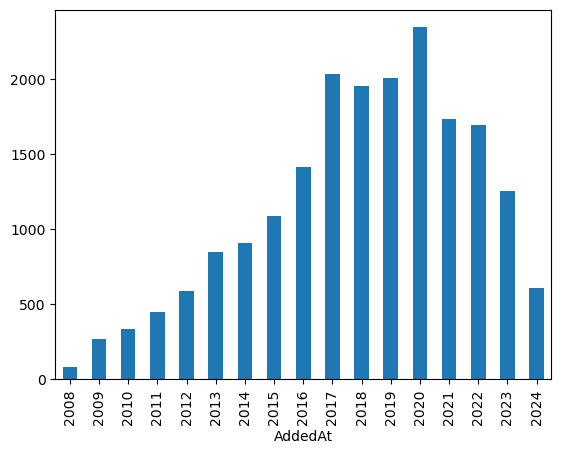

In [46]:
flattened_data["AddedAt"].value_counts().sort_index().plot(kind="bar")

In [47]:
field_median_ciation = (
    grouped_data.groupby("field").agg({"citation_count": "mean"}).reset_index()
)
field_median_ciation.sort_values("citation_count", ascending=False)

,field,citation_count
7,chemistry,12190.113208
36,library science,2963.161290
4,artificial intelligence,1709.482642
41,mathematical optimization,1588.510448
1,applied mathematics,1259.835979
...,...,...
46,multimedia,87.153846
51,philosophy,76.437500
53,political science,48.764706
59,sociology,44.125000


In [5]:
ref_age = flattened_data[
    flattened_data["year"].notnull() & flattened_data["AddedAt"].notnull()
].copy()
ref_age["age"] = ref_age["AddedAt"] - ref_age["year"]
ref_age["age"] = ref_age["age"].apply(lambda x: max(0, x))
ref_age

,title,normalized_venue,year,citation_count,authors,type,open_access,concepts,PostId,AddedAt,l1_field,field,age
0,Asynchronous completion token,Addison wesley longman publishing co inc ebooks,1997,8.0,"[{'name': 'Irfan Pyarali', 'id': '1840209'}, {...",[book],False,"[{'name': 'computer science', 'score': 0.63352...",37933,2008,computer network,computer network,11
1,Impact of high-intensity negotiated-style inte...,Journal of visual languages and computing,2005,4.0,NaN,[journal-article],False,"[{'name': 'computer science', 'score': 0.50277...",125285,2008,operating system,operating system,3
2,A note on the genuine Sieve of Eratosthenes,Journal of functional programming,2008,44.0,"[{'name': 'M. Nykänen', 'id': '1890836'}]","[JournalArticle, journal-article]",True,"[{'name': 'computer science', 'score': 0.39639...",80736,2008,algorithm,algorithm,0
3,Writing Hygienic Macros in Scheme with Syntax-...,NaN,1992,35.0,"[{'name': 'Kent Dybvigdyb', 'id': '2262888616'}]",[journal-article],False,"[{'name': 'computer science', 'score': 0.68237...",133356,2008,programming language,programming language,16
4,A consensus glossary of temporal database conc...,ACM SIGMOD Conference,1994,495.0,"[{'name': 'C. Dyreson', 'id': '1710939'}, {'na...",[journal-article],True,"[{'name': 'computer science', 'score': 0.74234...",25248,2008,database,database,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19577,XOR has no local minima: A case study in neura...,Neural Networks,1998,62.0,"[{'name': 'Len Hamey', 'id': '119899233'}]","[JournalArticle, journal-article]",False,"[{'name': 'computer science', 'score': 0.51772...",8057296,2011,algorithm,algorithm,13
19578,The Semantic Data Dictionary – An Approach for...,Data Intelligence,2020,24.0,"[{'name': 'S. M. Rashid', 'id': '145696537'}, ...","[JournalArticle, Review, journal-article]",True,"[{'name': 'computer science', 'score': 0.83299...",76351313,2023,data science,data science,3
19579,Validation of ICA-based myogenic artifact corr...,NeuroImage,2010,186.0,"[{'name': 'Brenton W. McMenamin', 'id': '27688...","[Study, JournalArticle, journal-article]",True,"[{'name': 'computer science', 'score': 0.51224...",28952067,2015,artificial intelligence,artificial intelligence,5
19580,Assembly dynamics of microtubules at molecular...,Nature,2006,569.0,"[{'name': 'J. Kerssemakers', 'id': '93557102'}...","[JournalArticle, journal-article]",False,"[{'name': 'biophysics', 'score': 0.60707754, '...",48000663,2017,biophysics,biology,11


In [6]:
field_year_ref = ref_age[ref_age["field"].notnull()].copy()
field_year_ref = (
    field_year_ref.groupby(["field", "AddedAt"]).agg({"age": list}).reset_index()
)
field_year_ref

,field,AddedAt,age
0,algorithm,2008,"[0, 5, 18, 12, 12, 9, 2, 13, 31, 12, 6]"
1,algorithm,2009,"[7, 10, 9, 20, 18, 2, 0, 3, 4, 2, 1, 12, 19, 1..."
2,algorithm,2010,"[3, 11, 8, 11, 19, 11, 5, 8, 4, 2, 2, 0, 2, 4,..."
3,algorithm,2011,"[15, 15, 4, 10, 18, 2, 12, 12, 6, 9, 3, 31, 4,..."
4,algorithm,2012,"[3, 31, 4, 2, 4, 10, 15, 3, 0, 7, 5, 8, 0, 8, ..."
...,...,...,...
931,world wide web,2020,"[7, 2, 2, 2, 0, 0, 0, 0, 6, 0]"
932,world wide web,2021,"[1, 10, 0, 25, 2, 0, 9, 1, 6, 1, 6, 1, 8, 1, 8]"
933,world wide web,2022,"[20, 9, 15, 14, 12, 4, 39, 2, 6, 39, 8, 12]"
934,world wide web,2023,"[0, 9, 9, 0]"


In [50]:
sum(field_year_ref["age"].sum()) / len(field_year_ref["age"].sum())

7.497559123454112

In [25]:
ref_age[ref_age["title"] == "MapReduce: simplified data processing on large clusters"]

,title,normalized_venue,year,citation_count,authors,type,open_access,concepts,PostId,AddedAt,l1_field,field,age
9314,MapReduce: simplified data processing on large...,Cacm,2018,25616.0,"[{'name': 'Muthu Dayalan', 'id': '71084179'}]","[JournalArticle, journal-article]",True,"[{'name': 'computer science', 'score': 0.85718...",26985557,2014,parallel computing,parallel computing,0


In [51]:
pd.set_option("display.max_rows", 10)
arxiv_refs = ref_age[ref_age["normalized_venue"] == "arXiv.org"]
arxiv_refs = arxiv_refs.groupby("title").agg({"age": "min"}).reset_index()
arxiv_refs.sample(100).to_json("arxiv_refs.json", orient="records")

In [ ]:
ref_age[
    (ref_age["field"] == "artificial intelligence")
    & (ref_age["AddedAt"] <= 2022)
    & (ref_age["AddedAt"] >= 2017)
].groupby("title").agg(
    {"AddedAt": list, "year": "min", "age": list, "field": "count"}
).reset_index().sort_values(
    "field", ascending=False
).head(
    20
)

,title,AddedAt,year,age,field
386,Batch Normalization: Accelerating Deep Network...,"[2019, 2021, 2017, 2017, 2017, 2018, 2017, 201...",2015,"[4, 6, 2, 2, 2, 3, 2, 2, 6, 2, 2, 3, 2, 3, 2, ...",53
331,Attention is All you Need,"[2022, 2020, 2021, 2021, 2022, 2019, 2020, 202...",2017,"[5, 3, 4, 4, 5, 2, 3, 3, 5, 2, 1, 3, 5, 2, 3, ...",52
2193,U-Net: Convolutional Networks for Biomedical I...,"[2020, 2018, 2018, 2022, 2020, 2022, 2019, 201...",2015,"[5, 3, 3, 7, 5, 7, 4, 4, 4, 4, 6, 6, 3, 4, 6, ...",52
696,Deep Residual Learning for Image Recognition,"[2019, 2017, 2017, 2020, 2020, 2017, 2021, 202...",2015,"[4, 2, 2, 5, 5, 2, 6, 7, 3, 3, 6, 2, 3, 7, 2, ...",38
995,Faster R-CNN: Towards Real-Time Object Detecti...,"[2017, 2017, 2017, 2020, 2019, 2017, 2020, 201...",2015,"[2, 2, 2, 5, 3, 2, 5, 2, 3, 2, 3, 2, 4, 4, 5, ...",31
...,...,...,...,...,...
808,Distributed Representations of Sentences and D...,"[2017, 2019, 2020, 2019, 2021, 2020, 2017, 201...",2014,"[3, 5, 6, 5, 7, 6, 3, 3, 7, 4, 3, 7, 4, 3, 4, ...",19
1872,SSD: Single Shot MultiBox Detector,"[2017, 2019, 2017, 2019, 2017, 2019, 2017, 201...",2016,"[1, 3, 1, 3, 1, 3, 1, 1, 1, 5, 2, 2, 1, 1, 2, ...",18
149,A guide to convolution arithmetic for deep lea...,"[2019, 2018, 2018, 2017, 2020, 2021, 2017, 202...",2016,"[3, 2, 2, 1, 4, 5, 1, 5, 4, 5, 1, 4, 2, 2, 3, ...",18
1074,Generative Adversarial Nets,"[2017, 2021, 2018, 2021, 2019, 2017, 2017, 201...",2014,"[3, 7, 4, 7, 5, 3, 3, 5, 3, 3, 8, 3, 3, 6, 2, ...",18


In [115]:
ref_age[
    (ref_age["title"] == "Deep Residual Learning for Image Recognition")
    & (ref_age["AddedAt"] <= 2017)
]

,title,normalized_venue,year,citation_count,authors,type,open_access,concepts,PostId,AddedAt,l1_field,field,age
2910,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015,177579.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, posted-content]",True,"[{'name': 'computer science', 'score': 0.75509...",43355803,2017,artificial intelligence,artificial intelligence,2
3224,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015,177579.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, posted-content]",True,"[{'name': 'computer science', 'score': 0.75509...",47849835,2017,artificial intelligence,artificial intelligence,2
3507,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015,177579.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, posted-content]",True,"[{'name': 'computer science', 'score': 0.75881...",43485342,2017,artificial intelligence,artificial intelligence,2
6281,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015,177579.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, posted-content]",True,"[{'name': 'computer science', 'score': 0.75509...",44093296,2017,artificial intelligence,artificial intelligence,2
7614,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015,177579.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, posted-content]",True,"[{'name': 'computer science', 'score': 0.75509...",37031106,2016,artificial intelligence,artificial intelligence,1
10053,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015,177579.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, posted-content]",True,"[{'name': 'computer science', 'score': 0.75881...",42907637,2017,artificial intelligence,artificial intelligence,2
13775,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2015,177579.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, posted-content]",True,"[{'name': 'computer science', 'score': 0.75509...",47456848,2017,artificial intelligence,artificial intelligence,2
15903,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2016,150735.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, proceedings-article]",True,"[{'name': 'computer science', 'score': 0.78272...",41193656,2016,artificial intelligence,artificial intelligence,0
16179,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2016,150735.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, proceedings-article]",True,"[{'name': 'computer science', 'score': 0.78272...",34654016,2016,artificial intelligence,artificial intelligence,0
17217,Deep Residual Learning for Image Recognition,Computer Vision and Pattern Recognition,2016,150735.0,"[{'name': 'Kaiming He', 'id': '39353098'}, {'n...","[JournalArticle, Conference, proceedings-article]",True,"[{'name': 'computer science', 'score': 0.78272...",46904460,2017,artificial intelligence,artificial intelligence,1


In [11]:
import plotly.graph_objects as go

fig = go.Figure()
for field in [
    "artificial intelligence",
    "programming language",
    "algorithm",
]:
    data = field_year_ref[field_year_ref["field"] == field]
    fig.add_trace(
        go.Scatter(
            x=data["AddedAt"],
            y=data["age"].apply(lambda x: sum(x) / len(x)),
            name=field,
            mode="lines+markers",
        )
    )
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    legend=dict(
        x=0.2,  # x position of the legend (0 is leftmost)
        y=0.95,  # y position of the legend (1 is topmost)
        orientation="h",  # horizontal orientation
        yanchor="top",  # anchor the legend at the top
        xanchor="left",  # anchor the legend at the left
    ),
    width=600,
    height=720,
    plot_bgcolor="#fff",  # transparent background
    paper_bgcolor="#fff",  # transparent background
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
with open("first_cite.eps", "wb") as f:
    f.write(fig.to_image("eps"))
fig.show()

In [66]:
field_ref_age = ref_age[ref_age["field"].notnull()].copy()
field_ref_age = (
    field_ref_age.groupby("field")
    .agg({"age": list, "year": list, "AddedAt": list, "title": "count"})
    .join(flattened_data.groupby("field").size().rename("count"))
    .rename(columns={"title": "filtered_count"})
    .reset_index()
)
pd.set_option("display.max_rows", 20)
meaningful_field_ref_age = field_ref_age[field_ref_age["count"] >= 100]
meaningful_field_ref_age = meaningful_field_ref_age.sort_values(
    "count", ascending=False
)
meaningful_field_ref_age.head(20)

,field,age,year,AddedAt,filtered_count,count
4,artificial intelligence,"[6, 1, 1, 3, 25, 4, 1, 0, 4, 5, 1, 9, 9, 3, 1,...","[2002, 2016, 2021, 2005, 1989, 2018, 2007, 201...","[2008, 2017, 2022, 2008, 2014, 2022, 2008, 201...",5601,5681
0,algorithm,"[0, 5, 18, 12, 12, 9, 2, 13, 31, 12, 6, 4, 7, ...","[2008, 2003, 1990, 1996, 1996, 1999, 2006, 199...","[2008, 2008, 2008, 2008, 2008, 2008, 2008, 200...",1818,1885
54,programming language,"[16, 6, 0, 9, 20, 4, 54, 1, 10, 10, 17, 3, 11,...","[1992, 2002, 2024, 1999, 1988, 2004, 1968, 200...","[2008, 2008, 2008, 2008, 2008, 2008, 2022, 200...",1182,1274
8,combinatorics,"[13, 30, 5, 0, 5, 41, 7, 0, 8, 10, 21, 0, 13, ...","[1995, 1978, 2003, 2009, 2003, 1981, 2002, 201...","[2008, 2008, 2008, 2008, 2008, 2022, 2009, 200...",634,662
50,parallel computing,"[2, 14, 5, 8, 3, 23, 7, 3, 9, 22, 26, 25, 3, 2...","[2006, 1994, 2003, 2014, 2014, 1986, 2007, 200...","[2008, 2008, 2008, 2022, 2017, 2009, 2014, 200...",628,656
47,natural language processing,"[2, 3, 0, 1, 9, 10, 14, 7, 2, 2, 1, 9, 1, 3, 3...","[2006, 2005, 2018, 2014, 2002, 2008, 2000, 201...","[2008, 2008, 2018, 2015, 2011, 2018, 2014, 202...",634,642
62,statistics,"[9, 5, 1, 1, 14, 1, 5, 11, 2, 5, 18, 1, 10, 23...","[2008, 2012, 2016, 2016, 2004, 2017, 2017, 201...","[2017, 2017, 2017, 2017, 2018, 2018, 2022, 202...",592,601
64,theoretical computer science,"[19, 0, 16, 4, 3, 7, 16, 5, 12, 15, 18, 20, 2,...","[1989, 2017, 1999, 2011, 2019, 2015, 1993, 201...","[2008, 2017, 2015, 2015, 2022, 2022, 2009, 201...",545,571
18,data mining,"[1, 13, 2, 4, 10, 10, 6, 3, 3, 26, 7, 2, 9, 2,...","[2007, 1995, 2020, 2018, 2007, 2004, 2003, 200...","[2008, 2008, 2022, 2022, 2017, 2014, 2009, 201...",484,497
41,mathematical optimization,"[6, 0, 4, 3, 42, 1, 6, 26, 4, 8, 1, 8, 39, 13,...","[2004, 2022, 2014, 2015, 1980, 2017, 2017, 199...","[2010, 2022, 2018, 2018, 2022, 2018, 2023, 201...",461,475


In [67]:
field_year_dist = meaningful_field_ref_age.copy()
field_year_dist = field_year_dist.explode("AddedAt")
field_year_dist = (
    field_year_dist.groupby(["field", "AddedAt"]).size().rename("count").reset_index()
)
field_year_dist

,field,AddedAt,count
0,algorithm,2008,11
1,algorithm,2009,26
2,algorithm,2010,34
3,algorithm,2011,60
4,algorithm,2012,77
...,...,...,...
504,world wide web,2020,10
505,world wide web,2021,15
506,world wide web,2022,12
507,world wide web,2023,4


In [97]:
import plotly.graph_objects as go

fig = go.Figure()
for field in [
    "artificial intelligence",
    "programming language",
    "algorithm",
]:
    data = field_year_dist[field_year_dist["field"] == field]
    fig.add_trace(
        go.Scatter(
            x=data["AddedAt"],
            y=data["count"],
            name=field,
            mode="lines+markers",
        )
    )
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    width=300,
    height=360,
    plot_bgcolor="#fff",  # transparent background
    paper_bgcolor="#fff",  # transparent background
    showlegend=False,
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")

fig.write_image("ref_by_year.svg")
fig.show()

In [69]:
field_pub_count = (
    ref_age.groupby("title")
    .agg("first")
    .groupby("field")
    .size()
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
    .rename(columns={0: "pub_count"})
)

In [70]:
from math import ceil, floor
import scipy.stats as stats
import numpy as np

def confidence_interval(data):
    mean = sum(data) / len(data)
    std = stats.sem(data)
    interval = stats.t.interval(0.95, len(data) - 1, loc=mean, scale=std)
    interval = f'({interval[0]:.2f}, {interval[1]:.2f})'
    return interval


meaningful_field_ref_age["age"] = meaningful_field_ref_age["age"].apply(
    lambda x: [y if y >= 0 else 0 for y in x]
)
meaningful_field_ref_age["age_median"] = meaningful_field_ref_age["age"].apply(
    lambda x: sorted(x)[len(x) // 2]
)
meaningful_field_ref_age["age_qr"] = meaningful_field_ref_age["age"].apply(
    lambda x: f"({sorted(x)[ceil(len(x) * 0.25)]}, {sorted(x)[floor(len(x) * 0.75)]})"
)
meaningful_field_ref_age["age_mean"] = meaningful_field_ref_age["age"].apply(
    lambda x: sum(x) / len(x)
)
meaningful_field_ref_age["age_standard_deviation"] = meaningful_field_ref_age[
    "age"
].apply(stats.sem)
meaningful_field_ref_age["age_confidence_interval"] = meaningful_field_ref_age[
    "age"
].apply(confidence_interval)

meaningful_field_ref_age["age_median"] = meaningful_field_ref_age["age"].apply(
    lambda x: sorted(x)[len(x) // 2]
)
# meaningful_field_ref_age["25"] = meaningful_field_ref_age["age"].apply(
#     lambda x: sorted(x)[int(len(x) * 0.25)]
# )
# meaningful_field_ref_age["75"] = meaningful_field_ref_age["age"].apply(
#     lambda x: sorted(x)[int(len(x) * 0.75)]
# )
# meaningful_field_ref_age["age_95"] = meaningful_field_ref_age["age"].apply(
#     lambda x: sorted(x)[int(len(x) * 0.95)]
# )
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_colwidth", 50)
meaningful_field_ref_age[
    [
        "field",
        "count",
        "age_median",
        "age_qr",
        "age_mean",
        "age_standard_deviation",
        "age_confidence_interval",
    ]
].join(field_median_ciation.set_index("field"), on="field").join(
    field_pub_count.set_index("field"), on="field"
).sort_values(
    "count", ascending=False
).head(
    20
)

,field,count,age_median,age_qr,age_mean,age_standard_deviation,age_confidence_interval,citation_count,pub_count
4,artificial intelligence,5681,3,"(1, 5)",4.256383,0.067874,"(4.12, 4.39)",1709.482642,3166
0,algorithm,1885,7,"(3, 15)",10.244774,0.240252,"(9.77, 10.72)",575.622891,1320
54,programming language,1274,7,"(3, 15)",10.341794,0.304526,"(9.74, 10.94)",299.482940,716
8,combinatorics,662,13,"(4, 24)",15.755521,0.535714,"(14.70, 16.81)",238.009091,533
50,parallel computing,656,4,"(2, 10)",7.452229,0.328347,"(6.81, 8.10)",218.086345,483
47,natural language processing,642,3,"(1, 7)",5.291798,0.271677,"(4.76, 5.83)",880.881402,372
62,statistics,601,8,"(3, 15)",11.025338,0.456757,"(10.13, 11.92)",1126.980119,505
64,theoretical computer science,571,5,"(2, 12)",8.482569,0.391491,"(7.71, 9.25)",612.888128,416
18,data mining,497,5,"(2, 9)",6.477273,0.287857,"(5.91, 7.04)",839.849624,383
41,mathematical optimization,475,6,"(3, 12)",8.563991,0.418042,"(7.74, 9.39)",1588.510448,321


In [20]:
all_citation = [citation for citation in grouped_data["citation_count"]]
sum(all_citation) / len(all_citation)

761.8376562791566

In [71]:
# Flatten the data into a single list
all_ages = [
    age for sublist in meaningful_field_ref_age["age"].tolist() for age in sublist
]

# Calculate the mean
mean_all_ages = sum(all_ages) / len(all_ages)

# Calculate the 95% confidence interval
ci_all_ages = confidence_interval(all_ages)

print(f"Mean age of all publications in all fields: {mean_all_ages}")
print(f"95% confidence interval of all publications in all fields: {ci_all_ages}")

Mean age of all publications in all fields: 7.322843891269888
95% confidence interval of all publications in all fields: (7.19, 7.46)


In [72]:
grouped_data["FirstCite"] = grouped_data["AddedAt"].apply(lambda x: min(x))
pd.set_option("display.max_rows", 10)
grouped_data

,title,normalized_venue,year,citation_count,open_access,PostId,field,AddedAt,FirstCite
0,Neural Network Methods for Natural Language P...,Computational Linguistics,2017.0,549.0,True,{48445189},artificial intelligence,[2018],2018
1,"""Low-Resource"" Text Classification: A Paramete...",Annual Meeting of the Association for Computat...,2023.0,52.0,True,{76724158},artificial intelligence,[2023],2023
2,"#ifdef Considered Harmful, or Portability Expe...",Usenix summer,1992.0,246.0,False,"{489434, 8012461, 21097319, 9294487}",computer security,"[2022, 2012, 2018, 2014]",2012
3,$2.00 Gas! Studying the Effects of a Gas Tax M...,Journal of Public Economics,2008.0,162.0,True,{75879031},economics,[2023],2023
4,"$\mu $ RNG: A 300–950 mV, 323 Gbps/W All-Digit...",IEEE Journal of Solid-State Circuits,2016.0,83.0,False,{61554191},algorithm,[2020],2020
...,...,...,...,...,...,...,...,...,...
13282,“One Against One” or “One Against All”: Which ...,International Conference on Frontiers in Handw...,2006.0,272.0,False,"{16728386, 16252899, 16793390}",artificial intelligence,"[2013, 2013, 2013]",2013
13283,"“Search, Show Context, Expand on Demand”: Supp...",IEEE Transactions on Visualization and Compute...,2009.0,257.0,False,{21893401},information retrieval,[2014],2014
13284,“Should This Loan be Approved or Denied?”: A L...,Journal of statistics education,2018.0,33.0,True,{64403934},operations research,[2020],2020
13285,“We Are Here to Help”Who Opens the Gate for Su...,Tsq transgender studies quarterly,2018.0,10.0,False,"{5017208, 58591979, 14537012, 5151693}",data science,"[2013, 2019, 2011, 2011]",2011


In [14]:
pub_interval = grouped_data.copy()

pub_interval["interval"] = pub_interval.apply(
    lambda x: (x["FirstCite"] - x["year"])
    if not (pd.isna(x["year"]) or pd.isna(x["FirstCite"]))
    else None,
    axis=1,
)
pub_interval = pub_interval[pub_interval["interval"].notnull()]
pub_interval["interval"] = pub_interval["interval"].astype(int)
pub_interval["interval"] = pub_interval["interval"].apply(
    lambda x: max(x, 0)
)
pd.set_option("display.max_rows", 10)
pub_interval

KeyError: 'FirstCite'

In [74]:
pub_interval.loc[pub_interval["FirstCite"] == 2008, "FirstCite"] = 2009
pub_interval[pub_interval["FirstCite"] == 2008]

,title,normalized_venue,year,citation_count,open_access,PostId,field,AddedAt,FirstCite,interval


In [75]:
import scipy.stats as stats

# Sample size
n = 10  # Example sample size
df = n - 1

# Desired confidence level
confidence_level = 0.95  # For a 95% confidence interval

# Two-tailed test, so we divide the alpha level by 2
alpha = 1 - confidence_level
t_value = stats.t.ppf(1 - alpha / 2, df)

print(f"T-value for {confidence_level*100}% confidence level and df={df}: {t_value}")

T-value for 95.0% confidence level and df=9: 2.2621571627409915


In [102]:
pub_interval.head()

,title,normalized_venue,year,citation_count,open_access,PostId,field,AddedAt,FirstCite,interval
0,Neural Network Methods for Natural Language P...,Computational Linguistics,2017.0,549.0,True,{48445189},artificial intelligence,[2018],2018,1
1,"""Low-Resource"" Text Classification: A Paramete...",Annual Meeting of the Association for Computat...,2023.0,52.0,True,{76724158},artificial intelligence,[2023],2023,0
2,"#ifdef Considered Harmful, or Portability Expe...",Usenix summer,1992.0,246.0,False,"{489434, 8012461, 21097319, 9294487}",computer security,"[2022, 2012, 2018, 2014]",2012,20
3,$2.00 Gas! Studying the Effects of a Gas Tax M...,Journal of Public Economics,2008.0,162.0,True,{75879031},economics,[2023],2023,15
4,"$\mu $ RNG: A 300–950 mV, 323 Gbps/W All-Digit...",IEEE Journal of Solid-State Circuits,2016.0,83.0,False,{61554191},algorithm,[2020],2020,4


In [ ]:
pub_interval[pub_interval["title"] == "Adam: A Method for Stochastic Optimization"]

,title,normalized_venue,year,citation_count,open_access,PostId,field,AddedAt,FirstCite,interval
1393,Adam: A Method for Stochastic Optimization,International Conference on Learning Represent...,2014.0,142334.0,True,"{60872321, 41450882, 49977348, 52474500, 60667...",mathematical optimization,"[2018, 2020, 2019, 2022, 2018, 2018, 2018, 201...",2016,2


In [13]:
# pub_interval = pub_interval[pub_interval["year"] >= 2008]

field_interval_year = (
    pub_interval.groupby(["field", "FirstCite"]).agg({"interval": list}).reset_index()
)
pd.set_option("display.max_rows", 10)
field_interval_year

NameError: name 'pub_interval' is not defined

In [12]:
import plotly.graph_objects as go

color_dict = {
    "artificial intelligence": (
        "rgba(99,110,250,1)",
        "rgba(99,110,250,0.16)",
    ),  # (line color, fill color)
    "programming language": ("rgb(226,91,77,1)", "rgba(226,91,77,0.16)"),
    "algorithm": ("rgba(0,204,150,1)", "rgba(0,204,150,0.16)"),
}

fig = go.Figure()
for field in [
    "artificial intelligence",
    "programming language",
    "algorithm",
]:
    data = field_interval_year[field_interval_year["field"] == field]

    # mean = data["interval"].apply(np.mean)
    # lower_quantile = data["interval"].apply(lambda x: np.percentile(x, 25))
    # upper_quantile = data["interval"].apply(lambda x: np.percentile(x, 75))

    mean = data["interval"].apply(lambda x: sum(x) / len(x))
    std = data["interval"].apply(lambda x: stats.sem(x) / 1.6 if stats.sem(x) > 2.4 else stats.sem(x))

    fig.add_trace(
        go.Scatter(
            x=data["FirstCite"],
            y=mean - std,
            name=field,
            mode="lines",
            line=dict(
                width=0, color=color_dict[field][0]
            ),  # Use line color from color_dict
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data["FirstCite"],
            y=mean + std,
            fill="tonexty",
            fillcolor=color_dict[field][1],  # Use fill color from color_dict
            line=dict(
                width=0, color=color_dict[field][0]
            ),  # Use line color from color_dict
            showlegend=False,
            mode="lines",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data["FirstCite"],
            y=mean,
            name=field,
            mode="lines+markers",
            line=dict(color=color_dict[field][0]),  # Use line color from color_dict
        )
    )

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    legend=dict(
        x=0.05,  # x position of the legend (0 is leftmost)
        y=0.99,  # y position of the legend (1 is topmost)
        orientation="h",  # horizontal orientation
        yanchor="top",  # anchor the legend at the top
        xanchor="left",  # anchor the legend at the left
        bgcolor='rgba(0,0,0,0)'
    ),
    width=340,
    height=400,
    plot_bgcolor="#fff",  # transparent background
    paper_bgcolor="#fff",  # transparent background
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="LightGray")
with open("first_cite.svg", "wb") as f:
    f.write(fig.to_image("svg"))
fig.show()

NameError: name 'field_interval_year' is not defined

In [98]:
field_interval = (
    pub_interval.groupby("field")
    .agg({"interval": list, "title": "count"})
    .rename({"title": "count"}, axis=1)
    .reset_index()
)
le = 1
ge = 10
field_interval[f"interval_le_{le}"] = field_interval["interval"].apply(
    lambda x: len([i for i in x if i <= le]) / len(x)
)
field_interval[f"interval_ge_{ge}"] = field_interval["interval"].apply(
    lambda x: len([i for i in x if i >= ge]) / len(x)
)
field_interval["interval_mean"] = field_interval["interval"].apply(
    lambda x: pd.Series(x).mean()
)
pd.set_option("display.max_rows", None)
meaningful_fields = field_interval[field_interval["count"] >= 100]
meaningful_fields.sort_values(["interval_le_1"], ascending=[False])

,field,interval,count,interval_le_1,interval_ge_10,interval_mean
45,medicine,"[1, 2, 4, 14, 0, 1, 0, 4, 3, 0, 0, 2, 2, 3, 1,...",127,0.503937,0.086614,2.834646
4,artificial intelligence,"[1, 0, 7, 1, 2, 5, 1, 9, 3, 4, 1, 7, 4, 2, 3, ...",3192,0.389724,0.124373,4.148810
37,machine learning,"[5, 3, 1, 3, 2, 3, 3, 6, 5, 11, 0, 1, 7, 0, 2,...",223,0.372197,0.080717,3.753363
47,natural language processing,"[0, 4, 2, 7, 1, 7, 15, 1, 16, 8, 3, 3, 11, 24,...",365,0.369863,0.186301,5.394521
19,data science,"[2, 6, 1, 2, 9, 0, 5, 0, 5, 3, 0, 4, 7, 6, 0, ...",167,0.329341,0.107784,4.532934
16,computer security,"[20, 0, 19, 8, 5, 2, 5, 6, 2, 0, 0, 5, 1, 4, 1...",203,0.315271,0.142857,4.714286
15,computer science,"[14, 35, 0, 0, 58, 12, 1, 1, 9, 0, 1, 4, 4, 7,...",158,0.297468,0.360759,9.481013
65,world wide web,"[10, 3, 4, 3, 1, 9, 1, 9, 6, 2, 3, 2, 8, 12, 1...",138,0.297101,0.144928,5.239130
5,biology,"[4, 18, 2, 0, 1, 2, 0, 0, 2, 5, 2, 0, 5, 1, 21...",214,0.294393,0.191589,6.682243
22,distributed computing,"[2, 0, 1, 2, 7, 5, 11, 0, 2, 12, 1, 0, 0, 1, 0...",173,0.283237,0.219653,6.630058


In [29]:
f1 = meaningful_fields[meaningful_fields["field"] == "machine learning"]
f2 = meaningful_fields[meaningful_fields["field"] == "programming language"]
f3 = meaningful_fields[meaningful_fields["field"] == "combinatorics"]

import plotly.figure_factory as ff

fig = ff.create_distplot(
    [f1["interval"].values[0], f2["interval"].values[0], f3["interval"].values[0]],
    ["machine learning", "programming language", "combinatorics"],
)
fig.show()

In [30]:
import plotly.graph_objects as go

fig = go.Figure()
violin_data = [
    f1["interval"].values[0],
    f2["interval"].values[0],
    f3["interval"].values[0],
]
violin_labels = ["machine learning", "programming language", "combinatorics"]
for y, name in zip(violin_data, violin_labels):
    fig.add_trace(
        go.Violin(
            y=y,
            name=name,
            jitter=0.2,
            box_visible=True,
            pointpos=-0.5,
            points=False,
            showlegend=False,
        )
    )
fig.update_layout(width=420, height=240, margin=dict(l=0, r=0, b=0, t=0), violingap=0, violinmode="overlay")
fig.show()

In [31]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(f1["interval"].values[0], f2["interval"].values[0])
U1, p

(37137.0, 6.801317146693462e-11)

In [32]:
import numpy as np

n1 = len(f1["interval"].values[0])
n2 = len(f2["interval"].values[0])

mean_U = n1 * n2 / 2
std_dev_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

z = (U1 - mean_U) / std_dev_U
z

-6.490871111963233